# Import Data

In [ ]:
!pip install pretty-midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 24.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 9.2 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592284 sha256=05e765a30eb5d17660516c56d3be68e319635423be8fb3d240cec615aab2a07c
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty-midi


In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import time
import pretty_midi
import pathlib
import glob
import pandas as pd
import collections

if tf.test.gpu_device_name():
  print("Default GPU Device: {}".format(tf.test.gpu_device_name()))

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)


# Download and extract the Maestro dataset if not already present
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
    tf.keras.utils.get_file(
        'maestro-v2.0.0-midi.zip',
        origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
        extract=True,
        cache_dir='.', cache_subdir='data',
    )

# # MAESTRO
filenames_MAESTRO = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames_MAESTRO))

# EDM
from google.colab import drive
drive.mount('/content/drive')
filenames_EDM = glob.glob("/content/drive/MyDrive/EDM_MIDI/AnyConv.com*.midi")
print('Number of files:', len(filenames_EDM))

# Set the sequence length for each example
seq_length = 100
vocab_size = 128
_SAMPLING_RATE = 44100

all_notes_MAESTRO = pd.DataFrame(columns=['pitch', 'start', 'end', 'step', 'duration'])
all_notes_EDM = pd.DataFrame(columns=['pitch', 'start', 'end', 'step', 'duration'])

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})




Default GPU Device: /device:GPU:0
Number of files: 1282
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of files: 1000


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

all_notes_MAESTRO = []
all_notes_EDM = []

#temporarily 5
num_files = 100
for f in filenames_MAESTRO[:num_files]:
  notes = midi_to_notes(f)
  all_notes_MAESTRO.append(notes)

num_files = 25
for f in filenames_EDM[:num_files]:
  notes = midi_to_notes(f)
  all_notes_EDM.append(notes)

all_notes_MAESTRO = pd.concat(all_notes_MAESTRO)
n_notes_MAESTRO = len(all_notes_MAESTRO)

all_notes_EDM = pd.concat(all_notes_EDM)
n_notes_EDM = len(all_notes_EDM)

key_order = ['pitch', 'step', 'duration']
train_notes_MAESTRO = np.stack([all_notes_MAESTRO[key] for key in key_order], axis=1)

train_notes_EDM = np.stack([all_notes_EDM[key] for key in key_order], axis=1)
# print(train_notes)

def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

notes_ds_MAESTRO = tf.data.Dataset.from_tensor_slices(train_notes_MAESTRO)
notes_ds_EDM = tf.data.Dataset.from_tensor_slices(train_notes_EDM)

sequence_length = 100
vocab_size = 128
seq_ds_MAESTRO = create_sequences(notes_ds_MAESTRO, seq_length, vocab_size)
seq_ds_EDM = create_sequences(notes_ds_EDM, seq_length, vocab_size)

batch_size = 64
buffer_size_MAESTRO = n_notes_MAESTRO - seq_length  # the number of items in the dataset
buffer_size_EDM = n_notes_EDM - seq_length

train_ds_MAESTRO = (seq_ds_MAESTRO
                    .shuffle(buffer_size_MAESTRO)
                    .batch(batch_size, drop_remainder=True)
                    .cache()
                    .prefetch(tf.data.experimental.AUTOTUNE))

train_ds_EDM = (seq_ds_EDM
                .shuffle(buffer_size_EDM)
                .batch(batch_size, drop_remainder=True)
                .cache()
                .prefetch(tf.data.experimental.AUTOTUNE))

# print(train_ds.element_spec)

# for inputs, labels in train_ds.take(1):  # Take one batch for inspection
#     print("Inputs shape:", inputs.shape)
#     print("Labels shape:", {key: labels[key].shape for key in labels})


# MusicVAE

In [ ]:
#implementation of vae
# need to base architecture on batch size and seq_length


#implemented in tensorflow
class VariationalAutoencoder(tf.keras.Model):
    def __init__(self, latent_features, input_size, enc_hidden_size, decoders_initial_size, dropout_rate, sequence_length, num_pitches):
        super(VariationalAutoencoder, self).__init__()

        self.latent_features = latent_features
        self.sequence_length = sequence_length
        self.num_pitches = num_pitches

        # Define the encoder
        self.encoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
            units=enc_hidden_size,
            input_shape=(sequence_length, 3),
            return_sequences=True,
            return_state=True,
            dropout=dropout_rate,
        ))

        # self.fc_mu = tf.keras.layers.Dense(latent_features)
        # self.fc_log_var = tf.keras.layers.Dense(latent_features)

        # Linear layer for encoding
        self.encoder_out = tf.keras.layers.Dense(latent_features * 2)

        # Linear layer for latent space to decoder initial size
        self.linear_z = tf.keras.layers.Dense(decoders_initial_size)

        # Dropout layers
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)
        self.word_dropout = tf.keras.layers.Dropout(rate=dropout_rate)


        # Define the conductor and note decoder
        self.conductor = tf.keras.layers.LSTM(
            units=decoders_initial_size,
            return_sequences=True,
            return_state=True,
            dropout=dropout_rate
        )

        self.reduce_dimension = tf.keras.layers.Dense(512, activation='tanh')

        self.decoder = tf.keras.layers.LSTM(
            units=decoders_initial_size,
            return_sequences=True,
            return_state=True,
            dropout=dropout_rate
        )

        self.linear_pitch = tf.keras.layers.Dense(num_pitches)
        self.linear_step = tf.keras.layers.Dense(1, activation='linear')
        self.linear_duration = tf.keras.layers.Dense(1, activation='linear')

    def call(self, x, training=False):
        # Encoder
        encoder_outputs, forward_h, forward_c, backward_h, backward_c = self.encoder(x)
        combined_hidden_states = tf.concat([forward_h, backward_h], axis=-1)
        x = self.encoder_out(encoder_outputs)
        mu, log_var = tf.split(x, num_or_size_splits=2, axis=-1)
        log_var = tf.nn.softplus(log_var)
        epsilon = tf.random.normal(shape=tf.shape(mu))
        z = mu + epsilon * tf.exp(log_var * 0.5)
        z = self.linear_z(z)

        # Conductor
        conductor_outputs, _, _ = self.conductor(z, training=training)
        # reduced_conductor_outputs = self.reduce_dimension(conductor_outputs)

        # Decoder
        last_embedding, _, _ = self.conductor(z[:, -1:, :], training=training)  # Use the last time step embedding

        if training:
            _, decoder_hidden, _ = self.decoder(tf.concat([last_embedding, x[:, -1:, :]], axis=-1), training=training)
        else:
            _, decoder_hidden, _ = self.decoder(tf.concat([last_embedding, tf.zeros_like(x[:, -1:, :])], axis=-1), training=training)

        pitch = self.linear_pitch(decoder_hidden)
        step = self.linear_step(decoder_hidden)
        duration = self.linear_duration(decoder_hidden)

        # pitch = tf.nn.softmax(pitch, axis=-1)

        return {"pitch": pitch, "step": step, "duration": duration}


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Assuming you have a dataset named 'train_dataset'
# Also assuming you have defined the sequence length, vocab size, and other parameters

# Define the VAE
latent_features = 512  # Adjust as needed
input_size = 128  # Adjust based on your input size
enc_hidden_size = 2048  # Adjust as needed
decoders_initial_size = 1024  # Adjust as needed
dropout_rate = 0.2  # Adjust as needed
num_pitches = 128  # Adjust based on your vocabulary size

vae = VariationalAutoencoder(latent_features, input_size, enc_hidden_size, decoders_initial_size, dropout_rate, sequence_length, num_pitches)


# Define the loss function
def vae_loss(y_true, y_pred):
    pitch_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    step_loss = tf.keras.losses.MeanSquaredError()
    duration_loss = tf.keras.losses.MeanSquaredError()

    total_loss = pitch_loss + step_loss + duration_loss
    return total_loss

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': tf.keras.losses.MeanSquaredError(),
      'duration': tf.keras.losses.MeanSquaredError(),
}


# Compile the model
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
vae.compile(optimizer=optimizer, loss=loss)

# Train the model with a validation split
# print(train_ds)
# losses = vae.evaluate(train_ds, return_dict=True)
# vae.fit(train_ds, epochs=5, batch_size=32)
vae.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=10,
        verbose=1,
        restore_best_weights=True),
]

epochs = 50

history = vae.fit(
    train_ds_EDM,
    epochs=epochs,
    steps_per_epoch = 10,
    callbacks=callbacks,
)

Epoch 1/50
10/10 [==============================] - 135s 766ms/step - loss: 0.2687 - duration_loss: 0.0224 - pitch_loss: 4.8467 - step_loss: 0.0039
Epoch 2/50
10/10 [==============================] - 7s 735ms/step - loss: 0.2715 - duration_loss: 0.0256 - pitch_loss: 4.8412 - step_loss: 0.0038
Epoch 3/50
10/10 [==============================] - 7s 732ms/step - loss: 0.2700 - duration_loss: 0.0253 - pitch_loss: 4.8237 - step_loss: 0.0035
Epoch 4/50
10/10 [==============================] - 7s 769ms/step - loss: 0.2579 - duration_loss: 0.0158 - pitch_loss: 4.7882 - step_loss: 0.0027
Epoch 5/50
10/10 [==============================] - 7s 752ms/step - loss: 0.2429 - duration_loss: 0.0088 - pitch_loss: 4.6102 - step_loss: 0.0036
Epoch 6/50
10/10 [==============================] - 7s 767ms/step - loss: 0.2291 - duration_loss: 0.0071 - pitch_loss: 4.4237 - step_loss: 7.7880e-04
Epoch 7/50
10/10 [==============================] - 20s 2s/step - loss: 0.2261 - duration_loss: 0.0051 - pitch_loss: 4

# LSTM Model

In [ ]:
import keras.backend as K

def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

### Base LSTM Model
# input_shape = (seq_length, 3)
# learning_rate = 0.001

# inputs = tf.keras.Input(input_shape)
# x = tf.keras.layers.LSTM(128)(inputs)

# outputs = {
#   'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
#   'step': tf.keras.layers.Dense(1, name='step')(x),
#   'duration': tf.keras.layers.Dense(1, name='duration')(x),
# }

# model = tf.keras.Model(inputs, outputs)

### Modified Double-Stack LSTM, from
learning_rate = 0.001
input_shape = (seq_length, 3)
inputs = tf.keras.Input(input_shape)
# x = tf.keras.layers.LSTM(256, return_sequences = True)(inputs)
# x = tf.keras.layers.Embedding(256, 256)(x)
# x = tf.keras.layers.LSTM(256, return_sequences = True)(x)
x = tf.keras.layers.LSTM(256, return_sequences = True)(inputs)

e = tf.keras.layers.Dense(1, activation='tanh')(x)
e = tf.keras.layers.Reshape([-1])(e)
alpha = tf.keras.layers.Activation('softmax')(e)

alpha_repeated = tf.keras.layers.Permute([2, 1])(tf.keras.layers.RepeatVector(256)(alpha))

c = tf.keras.layers.Multiply()([x, alpha_repeated])
c = tf.keras.layers.Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(256,))(c)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(c),
  'step': tf.keras.layers.Dense(1, name='step')(c),
  'duration': tf.keras.layers.Dense(1, name='duration')(c),
}

model = tf.keras.Model(inputs, outputs)



loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

epochs = 50

history = model.fit(
    train_ds_MAESTRO,
    epochs=epochs,
    steps_per_epoch = 10,
    callbacks=callbacks,
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 3)]             0         []                            
                                                                                                  
 lstm_3 (LSTM)               (None, 100, 256)             266240    ['input_1[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 100, 1)               257       ['lstm_3[0][0]']              
                                                                                                  
 reshape (Reshape)           (None, 100)                  0         ['dense_6[0][0]']             
                                                                                              

# Generate Music

In [ ]:
#training and display audio
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

temperature = 1
num_predictions = 600
file_num = 125
# print(filenames[249])
raw_notes_MAESTRO = midi_to_notes(filenames_MAESTRO[file_num])
raw_notes_EDM = midi_to_notes(filenames_EDM[file_num])
key_order = ['pitch', 'step', 'duration']

sample_notes_MAESTRO = np.stack([raw_notes_MAESTRO[key] for key in key_order], axis=1)
sample_notes_EDM = np.stack([raw_notes_EDM[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes_MAESTRO = (
    sample_notes_MAESTRO[:seq_length] / np.array([vocab_size, 1, 1]))
input_notes_EDM = (
    sample_notes_EDM[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step_real, duration_real = predict_next_note(input_notes_EDM, vae, temperature)
  pitch_real, step, duration = predict_next_note(input_notes_MAESTRO, model, temperature)
  start = prev_start + step_real
  end = start + duration_real
  fused_note = (pitch_real, step_real, duration_real)
  MAESTRO_note = (pitch_real, step, duration)
  EDM_note = (pitch, step_real, duration_real)
  generated_notes.append((*fused_note, start, end))

  input_notes_MAESTRO = np.delete(input_notes_MAESTRO, 0, axis=0)
  input_notes_MAESTRO = np.append(input_notes_MAESTRO, np.expand_dims(MAESTRO_note, 0), axis=0)

  input_notes_EDM = np.delete(input_notes_EDM, 0, axis=0)
  input_notes_EDM = np.append(input_notes_EDM, np.expand_dims(EDM_note, 0), axis=0)

  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

# pm = pretty_midi.PrettyMIDI(filenames[8])
# instrument = pretty_midi.instruments[38]
# instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
program_number = 38
instrument_name = pretty_midi.program_to_instrument_name(program_number)


out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)


1/1 [==============================] - 0s 20ms/step


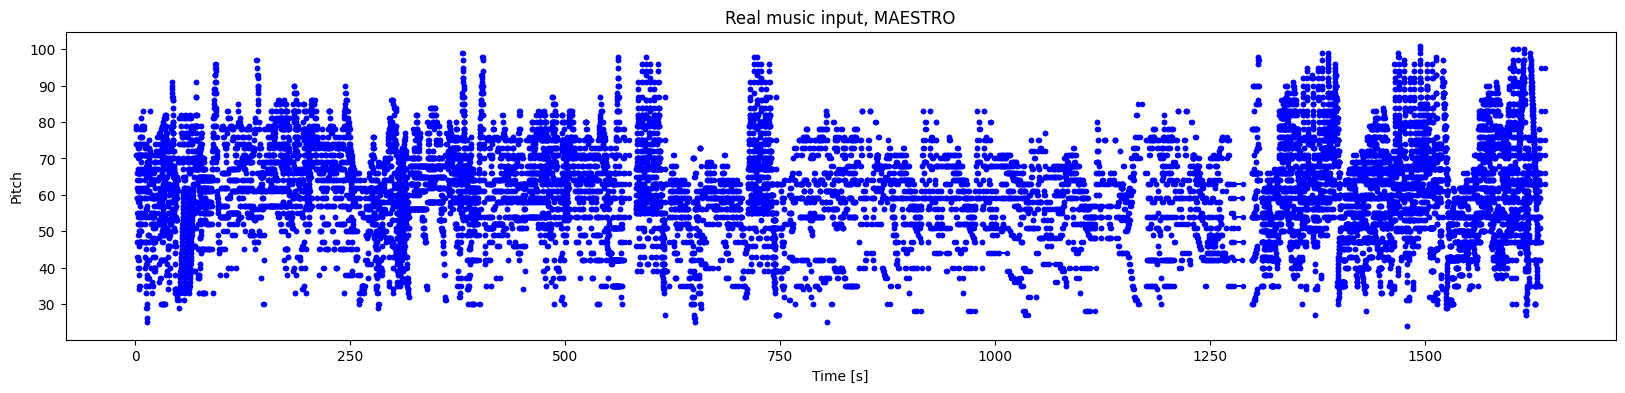

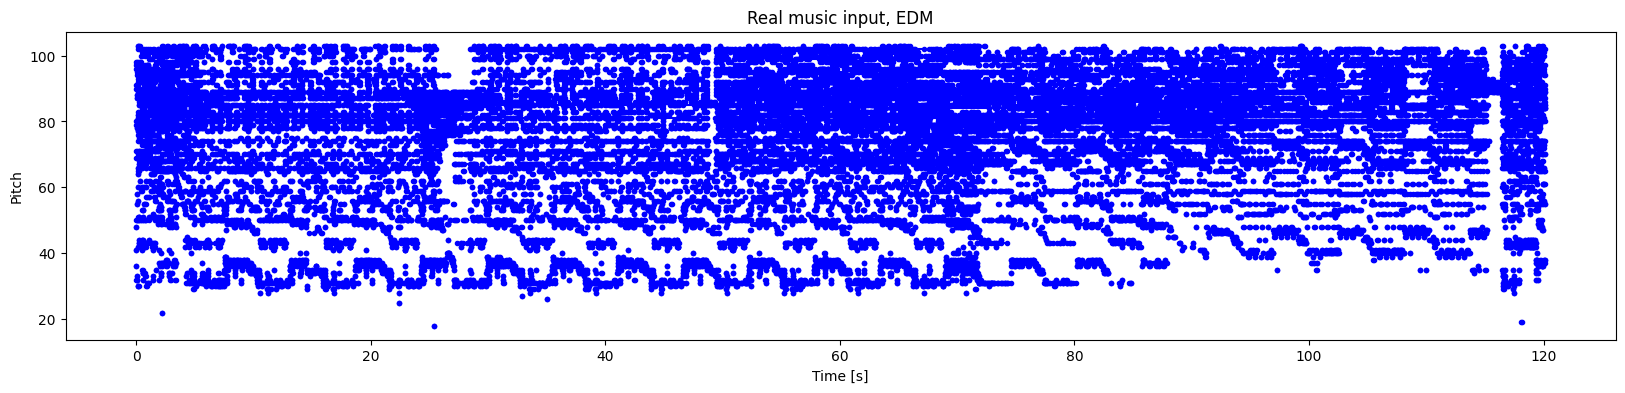

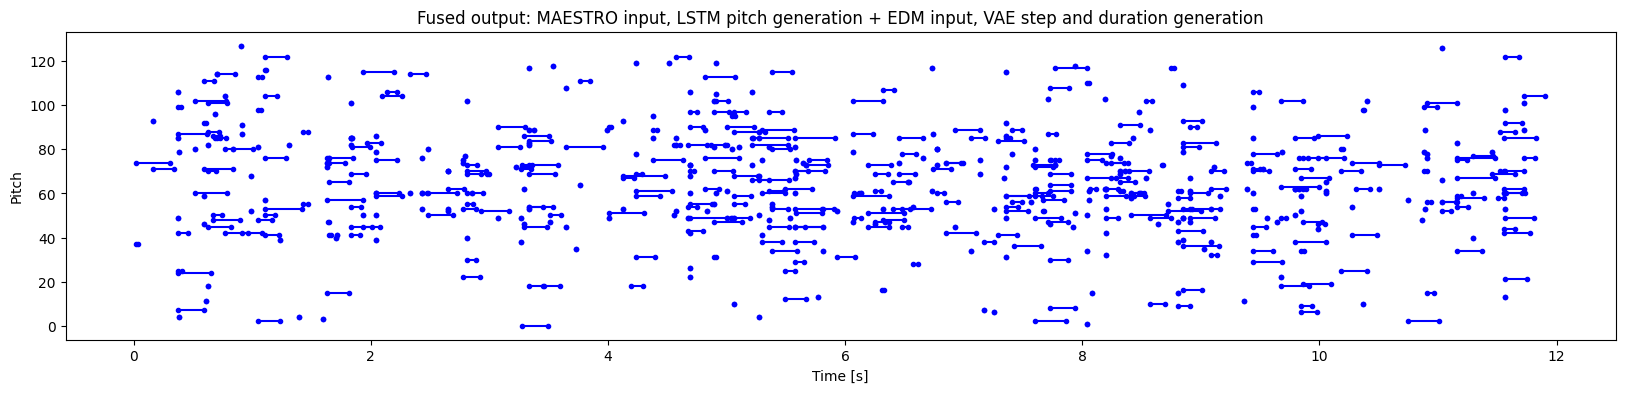

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, title: str, count: Optional[int] = None):
  if count:
    title = f'{title}: First {count} notes'
  else:
    title = f'{title}'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

plot_piano_roll(raw_notes_MAESTRO, "Real music input, MAESTRO")
plot_piano_roll(raw_notes_EDM, "Real music input, EDM")
plot_piano_roll(generated_notes, "Fused output: MAESTRO input, LSTM pitch generation + EDM input, VAE step and duration generation")

In [ ]:
out_file_MAESTRO = 'maestro.mid'
out_pm = notes_to_midi(
    raw_notes_MAESTRO, out_file=out_file_MAESTRO, instrument_name=instrument_name)
display_audio(out_pm)

In [ ]:
out_file_EDM = 'edm.mid'
out_pm = notes_to_midi(
    raw_notes_EDM, out_file=out_file_EDM, instrument_name=instrument_name)
display_audio(out_pm)

In [ ]:
generated_notes.head(10)

pitch      step  duration     start       end
0    102  0.044410  0.000000  0.044410  0.044410
1     60  0.000000  0.235886  0.044410  0.280297
2    108  0.000000  0.041081  0.044410  0.085491
3     80  0.017394  0.000000  0.061804  0.061804
4    107  0.000000  0.344987  0.061804  0.406792
5     11  0.082394  0.000000  0.144199  0.144199
6    124  0.000000  0.000000  0.144199  0.144199
7     49  0.100371  0.001874  0.244570  0.246444
8     58  0.000000  0.019731  0.244570  0.264301
9     48  0.000000  0.214270  0.244570  0.458840

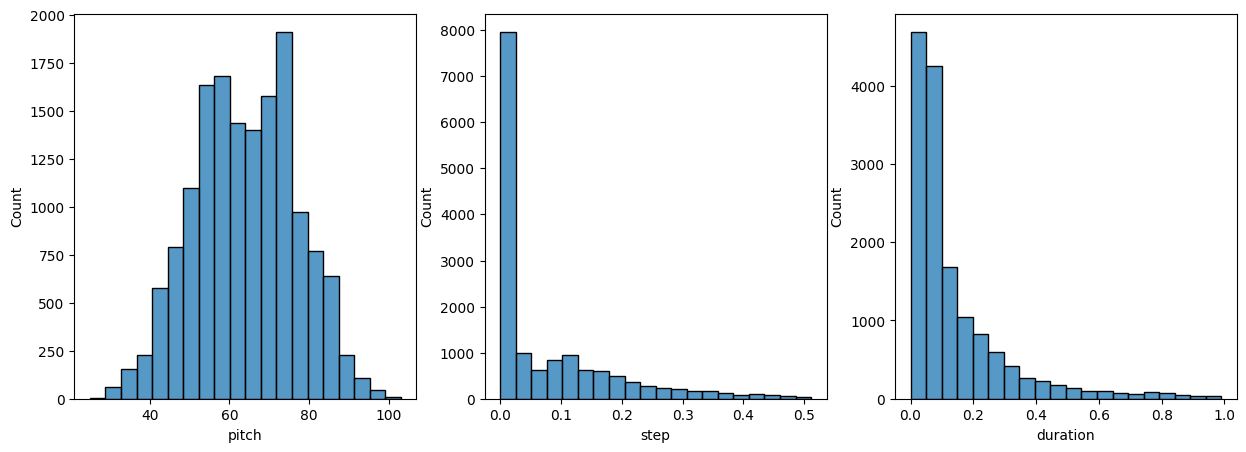

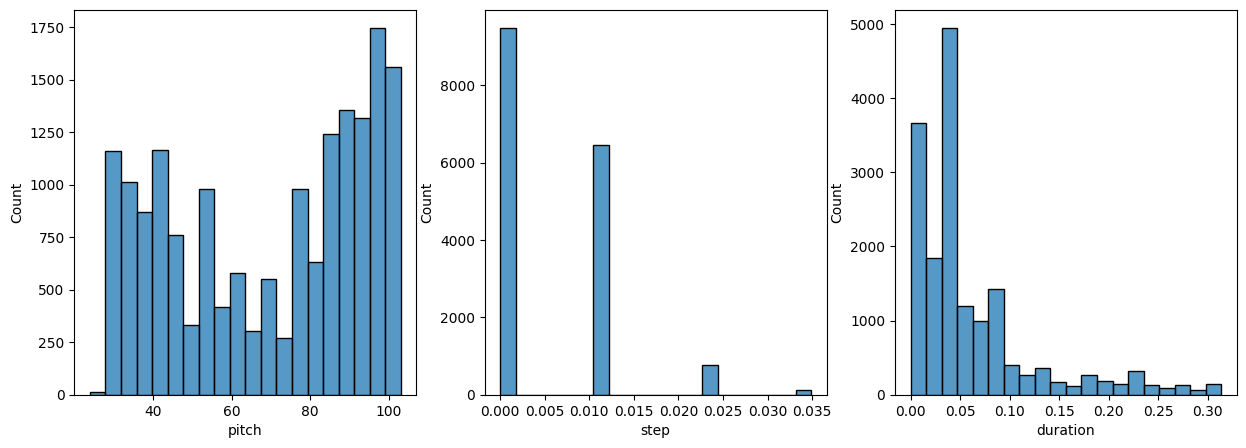

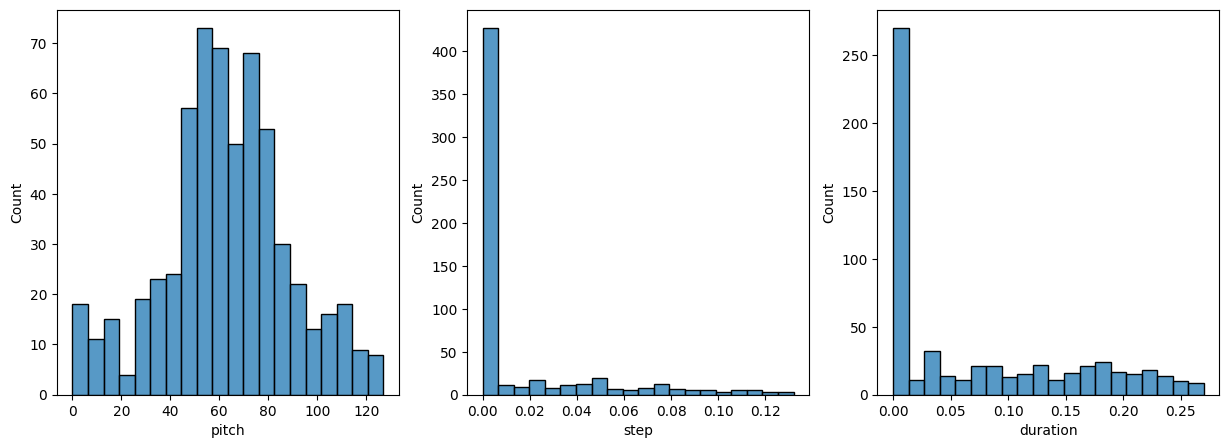

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

plot_distributions(raw_notes_MAESTRO)
plot_distributions(raw_notes_EDM)
plot_distributions(generated_notes)
# print(len(raw_notes))
